### 🧭 Análise Espacial com PySAL (usando `mediana_mean`)

#### 🎯 Objetivo geral

O objetivo é investigar se a métrica **`mediana_mean`** apresenta **padrões espaciais significativos**, ou seja:

> Regiões com valores altos estão próximas de outras regiões altas?  
> Ou os valores altos estão distribuídos aleatoriamente no espaço?

Essa análise identifica **autocorrelação espacial**, isto é, a relação entre o valor de uma região e o valor médio das suas regiões vizinhas.

---

#### 🧩 1️⃣ Moran Global (I de Moran)

O **Moran I** mede a **autocorrelação espacial global**: quão semelhantes são os valores de uma variável entre regiões vizinhas.

- Intervalo típico: **-1 ≤ I ≤ +1**
- Interpretação:
  - **I > 0:** regiões próximas têm valores semelhantes (alto com alto, baixo com baixo) → padrão **agrupado**  
  - **I < 0:** regiões vizinhas têm valores opostos (alto com baixo) → padrão **disperso**  
  - **I ≈ 0:** ausência de padrão → distribuição **aleatória**
- O valor de `p_norm` indica **significância estatística** (quanto menor, mais confiável).

**Exemplo:**

> I = 0.45, p = 0.001 → forte autocorrelação positiva: regiões próximas compartilham valores semelhantes de `mediana_mean`.

---

#### 🧭 2️⃣ Moran Local (LISA — Local Indicators of Spatial Association)

Enquanto o Moran Global mostra o **padrão geral**, o **LISA** revela **onde** esses padrões ocorrem.

Cada região é classificada segundo seu valor e o valor médio dos vizinhos:

| Quadrante | Interpretação |
|------------|----------------|
| **HH (High-High)** | Região alta cercada por regiões altas → *hotspot de alta intensidade* |
| **LL (Low-Low)** | Região baixa cercada por regiões baixas → *coldspot de baixa intensidade* |
| **HL (High-Low)** | Região alta cercada por baixas → *outlier local* |
| **LH (Low-High)** | Região baixa cercada por altas → *outlier local inverso* |
| **NS (Not Significant)** | Sem padrão estatisticamente significativo |

O resultado é um **mapa de clusters LISA**, destacando:
- Áreas com concentração de valores altos/baixos
- Regiões isoladas com comportamento atípico

---

#### 🔥 3️⃣ Getis-Ord Gi* (Hotspot / Coldspot)

O **Gi\*** mede a **intensidade local de agrupamento**, mas com lógica diferente do Moran.

- Em vez de comparar com o conjunto inteiro, analisa **somente o entorno imediato**:
  - **Hotspot:** alta concentração local de valores altos e significativa (z > 0, p ≤ α)
  - **Coldspot:** concentração local de valores baixos (z < 0, p ≤ α)
  - **NS:** nenhuma concentração significativa

O resultado costuma ser um **mapa de calor espacial**, evidenciando “ilhas de calor” (hotspots) e “ilhas frias” (coldspots).

---

#### 📈 4️⃣ Lag espacial (`lag_mediana_mean`)

O **lag espacial** representa a **média ponderada dos valores das regiões vizinhas**, segundo a matriz de pesos `W`.

Serve para construir o **diagrama de dispersão de Moran**:

- Eixo X → valor centrado da região (`y - mean(y)`)
- Eixo Y → valor centrado dos vizinhos (`Wy - mean(Wy)`)
- A inclinação da reta é o próprio **I de Moran**

---

#### 🧭 5️⃣ Resumo comparativo

| Nível | Estatística | Mostra o quê |
|-------|--------------|--------------|
| Global | Moran I | Se há autocorrelação espacial em todo o mapa |
| Local | LISA | Onde estão os clusters HH/LL e outliers HL/LH |
| Local | Getis-Ord Gi* | Onde há hotspots/coldspots de intensidade |
| Local | Lag espacial | O quanto cada região se aproxima da média dos vizinhos |

---

#### ✅ Conclusão

Essas análises em conjunto permitem compreender:
- **Se** existe dependência espacial nos dados (`Moran I`)
- **Onde** ela se manifesta (`LISA` e `Gi*`)
- **Qual a natureza do padrão** (agrupamento, dispersão, aleatoriedade)
- **Como** cada região se relaciona com o seu entorno (`lag_mediana_mean`)


#### Bibliotecas e Montagem do arquivo

In [1]:
!pip freeze > requirements.txt


In [3]:

!pip install gdown

In [ ]:
# Bibliotecas
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


# PySAL
from libpysal.weights import Queen, KNN, lag_spatial
from esda import Moran, Moran_Local
from esda.getisord import G_Local

# Configurações gerais de exibição
pd.set_option("display.max_columns", None)
plt.style.use("default")

In [6]:
# Leitura e preparação da geometria (Demora menos de um minuto pra rodar)

import geopandas as gpd
import pandas as pd

# Caminhos dos arquivos
path_excel = "bases_analises/summary_bootstrap_regioes.xlsx"
path_shape = "BR_Municipios_2023/BR_Municipios_2023.shp"

# 1) Ler o summary sem geometria
df_summary = pd.read_excel(path_excel)

# 2) Ler o shapefile dos municípios
gdf_mun = gpd.read_file(path_shape)

# 3) Renomear o código da região para bater com o Excel (se necessário)
if "CD_RGI" in gdf_mun.columns and "cod_regiao" not in gdf_mun.columns:
    gdf_mun = gdf_mun.rename(columns={"CD_RGI": "cod_regiao"})

# 4) Converter tipos para garantir merge correto
df_summary["cod_regiao"] = pd.to_numeric(df_summary["cod_regiao"], errors="coerce").astype("Int64")
gdf_mun["cod_regiao"] = pd.to_numeric(gdf_mun["cod_regiao"], errors="coerce").astype("Int64")

# 5) Criar geometria agregada por região
gdf_regioes = gdf_mun.dissolve(by="cod_regiao", as_index=False)

# 6) Fazer o merge do summary com as geometrias das regiões
gdf_summary = df_summary.merge(
    gdf_regioes[["cod_regiao", "geometry"]],
    on="cod_regiao",
    how="left"
)

# 7) Transformar em GeoDataFrame final
gdf_summary = gpd.GeoDataFrame(gdf_summary, geometry="geometry", crs=gdf_regioes.crs)

print("✔ gdf_summary criado com sucesso!")
print("CRS:", gdf_summary.crs)
print("Regiões com geometria ausente:", gdf_summary["geometry"].isna().sum())


✔ gdf_summary criado com sucesso!
CRS: EPSG:4674
Regiões com geometria ausente: 0


In [7]:
GDF = gdf_summary.copy()

In [8]:
GDF.head()

,cod_regiao,nome_regiao,coluna,ano,media_mean,media_std,media_ci_lower,media_ci_upper,mediana_mean,mediana_std,mediana_mediana,p25_mediana,p75_mediana,inc_media_amp,inc_media_cv,skew_media,kurt_media,n_peaks,diagnostico_estabilidade,diagnostico_assimetria,diagnostico_curtose,diagnostico_multimodal,valor_representativo,geometry
0,350001,São Paulo,ipca_alimentos_bebidas,2018,4.030782,0.0,4.030782,4.030782,4.030782,0.0,4.030782,4.030782,4.030782,0.0,4.406978e-16,1.001503,-2.004012,0.0,Alta estabilidade,Assimétrica à direita,Platicúrtica (achatada),Multimodal,4.030782,"POLYGON ((-47.00221 -24.05627, -47.00285 -24.0..."
1,350001,São Paulo,ipca_alimentos_bebidas,2019,6.364091,0.0,6.364091,6.364091,6.364091,0.0,6.364091,6.364091,6.364091,0.0,1.395609e-16,NaN,NaN,0.0,Alta estabilidade,Sem dados,Sem dados,Multimodal,6.364091,"POLYGON ((-47.00221 -24.05627, -47.00285 -24.0..."
2,350001,São Paulo,ipca_alimentos_bebidas,2020,14.113456,0.0,14.113456,14.113456,14.113456,0.0,14.113456,14.113456,14.113456,0.0,1.258626e-16,NaN,NaN,0.0,Alta estabilidade,Sem dados,Sem dados,Multimodal,14.113456,"POLYGON ((-47.00221 -24.05627, -47.00285 -24.0..."
3,350001,São Paulo,ipca_artigos_residencia,2018,3.759616,0.0,3.759616,3.759616,3.759616,0.0,3.759616,3.759616,3.759616,0.0,3.543627e-16,1.001503,-2.004012,0.0,Alta estabilidade,Assimétrica à direita,Platicúrtica (achatada),Multimodal,3.759616,"POLYGON ((-47.00221 -24.05627, -47.00285 -24.0..."
4,350001,São Paulo,ipca_artigos_residencia,2019,-0.377431,0.0,-0.377431,-0.377431,-0.377431,0.0,-0.377431,-0.377431,-0.377431,0.0,-1.470762e-16,NaN,NaN,0.0,Alta estabilidade,Sem dados,Sem dados,Multimodal,-0.377431,"POLYGON ((-47.00221 -24.05627, -47.00285 -24.0..."


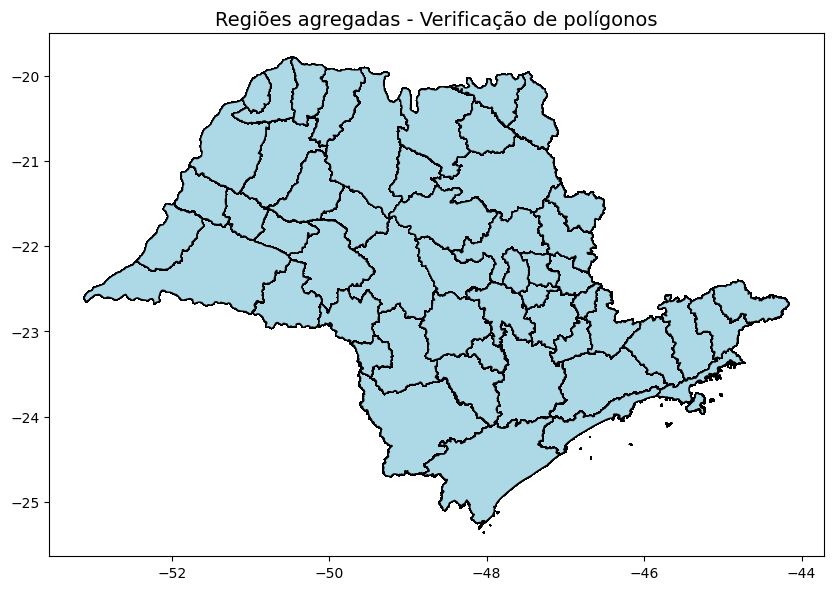

In [9]:
#Cerca de 30 segundos pra rodar (pc marcos)
fig, ax = plt.subplots(figsize=(10, 8))
gdf_summary.plot(ax=ax, color='lightblue', edgecolor='k')
ax.set_title("Regiões agregadas - Verificação de polígonos", fontsize=14)
plt.show()

#### Análise de modalidade


In [10]:
tabela_multimodal = (
    GDF
    .pivot_table(
        index="coluna",
        columns="diagnostico_multimodal",
        values="cod_regiao",   # qualquer coluna não-nula serve
        aggfunc="count",
        fill_value=0
    )
)

# Versão em proporções
tabela_multimodal_prop = tabela_multimodal.div(tabela_multimodal.sum(axis=1), axis=0)

tabela_multimodal
tabela_multimodal_prop


diagnostico_multimodal,Bimodal,Multimodal,Sem dados,Unimodal
coluna,,,,
ipca_alimentos_bebidas,0.0,0.63522,0.36478,0.0
ipca_artigos_residencia,0.0,1.0,0.0,0.0
ipca_comunicacao,0.0,0.943396,0.056604,0.0
ipca_despesas_pessoais,0.0,0.811321,0.188679,0.0
ipca_educacao,0.0,0.849057,0.150943,0.0
ipca_geral,0.0,0.805031,0.194969,0.0
ipca_habitacao,0.0,0.465409,0.534591,0.0
ipca_saude_cuidados_pessoais,0.0,0.610063,0.389937,0.0
ipca_transportes,0.0,0.666667,0.333333,0.0


In [11]:
#VARIAVEIS de IPCA não são unimodais
vars_remover_ipca = [
    "ipca_alimentos_bebidas",
    "ipca_artigos_residencia",
    "ipca_comunicacao",
    "ipca_despesas_pessoais",
    "ipca_educacao",
    "ipca_geral",
    "ipca_habitacao",
    "ipca_saude_cuidados_pessoais",
    "ipca_transportes",
    "ipca_vestuario",
]


In [12]:

#VARIAVEIS CUJA MEDIA É INSTÁVEL E PODE PREJUDICAR A ANÁLISE
vars_remover_taxa_qtd = [
    "taxa_qtd_formal_Indústrias_Extrativas",
    "taxa_qtd_formal_Eletricidade_e_Gás",
    "taxa_qtd_formal_Atividades_Imobiliárias",
    "taxa_qtd_formal_Serviços_Domésticos",
    "taxa_qtd_formal_Artes_e_Cultura",
    "taxa_qtd_formal_Informação_e_Comunicação",
    "taxa_qtd_formal_Educação",
    "taxa_qtd_formal_Saúde",
    "taxa_qtd_formal_Serviços_Administrativos",
    "taxa_qtd_formal_Construção",
    "taxa_qtd_formal_Saneamento_e_Resíduos",
]


In [13]:
#remoção apenas das variáveis de IPCA
GDF= GDF[~GDF["coluna"].isin(vars_remover_ipca)]

A maior parte das variáveis de interesse na análise são majoritariamente unimodais

#### Construção dos pesos espaciais

In [14]:
# %% [1] Sanidade do GDF
assert "GDF" in globals(), "GDF não está definido."
for col in ["coluna", "mediana_mean", "geometry"]:
    assert col in GDF.columns, f"Coluna obrigatória ausente: {col}"
print(f"✔ GDF OK | linhas={len(GDF)} | colunas essenciais presentes.")


✔ GDF OK | linhas=6996 | colunas essenciais presentes.


In [15]:
import os
import pickle
import gdown  

pkl_path = "w_queen_full.pkl"

# ID do arquivo no Google Drive 
file_id = "1P1-YoYM10AAN76VcT3TAXG2XrLHYxQIj" 

if not os.path.exists(pkl_path):
    # monta a URL de download a partir do ID
    url = f"https://drive.google.com/uc?id={file_id}"
    print("Arquivo pkl não encontrado. Baixando do Google Drive...")
    gdown.download(url, pkl_path, quiet=False)

# a partir daqui, o arquivo deve existir (baixado ou já presente)
with open(pkl_path, "rb") as f:
    Wm = pickle.load(f)
    print("Wm carregado do arquivo.")


Wm carregado do arquivo.


In [ ]:
############ NÃO APENAS SE DER ERRO NO CÓDIGO ACIMA ############
from libpysal.weights import Queen
Wm = Queen.from_dataframe(GDF, use_index=True)
Wm.transform = "R"
############ NÃO APENAS SE DER ERRO NO CÓDIGO ACIMA ############

In [16]:
#  Utilitários para as análises espaciais

def _require_columns(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Faltam colunas no GDF: {missing}")

def _lisa_quadrant(y, wy):
    return np.select(
        [
            (y > 0) & (wy > 0),  # HH
            (y < 0) & (wy < 0),  # LL
            (y > 0) & (wy < 0),  # HL
            (y < 0) & (wy > 0),  # LH
        ],
        ["HH", "LL", "HL", "LH"],
        default="NS"
    )

def _apply_significance(mask_sig, cats):
    cats_out = np.array(cats, dtype=object)
    cats_out[~mask_sig] = "NS"
    return cats_out


In [17]:
from libpysal.weights import W as WClass
def analyze_variable_by_median(GDF, var_name, W_full, alpha=0.05, permutations=999):
    _require_columns(GDF, ["coluna", "mediana_mean", "geometry"])

    # 1) Filtra linhas da variável e remove NaN
    gdf_var = GDF.loc[GDF["coluna"] == var_name].copy()
    gdf_var = gdf_var[~gdf_var["mediana_mean"].isna()].copy()
    if gdf_var.empty:
        raise ValueError(f"Nenhuma linha com 'coluna' == {var_name} e mediana_mean válida.")

    # 2) Garante ordem consistente com W_full.id_order
    ids_subset_sorted = [i for i in W_full.id_order if i in gdf_var.index]
    if not ids_subset_sorted:
        raise ValueError(f"Índices do subset de '{var_name}' não aparecem em W.id_order.")

    gdf_var = gdf_var.reindex(ids_subset_sorted).copy()

    # 3) Submatriz de pesos construída manualmente
    W_sub = _build_W_sub(W_full, ids_subset_sorted)

    # 4) Série e lag
    y  = gdf_var["mediana_mean"].astype(float).values
    wy = lag_spatial(W_sub, y)
    gdf_var["lag_mediana_mean"] = wy

    # 5) Estatísticas espaciais
    moran = Moran(y, W_sub, permutations=permutations)
    lisa  = Moran_Local(y, W_sub, permutations=permutations)
    gi    = G_Local(y, W_sub, permutations=permutations)

    # 6) LISA clusters
    y_c  = y - y.mean()
    wy_c = lag_spatial(W_sub, y_c)
    quads    = _lisa_quadrant(y_c, wy_c)
    sig_mask = lisa.p_sim <= alpha

    gdf_var["Ii"]           = lisa.Is
    gdf_var["p_lisa"]       = lisa.p_sim
    gdf_var["z_lisa"]       = lisa.z_sim
    gdf_var["cluster_LISA"] = _apply_significance(sig_mask, quads)

    # 7) Gi* clusters
    gdf_var["Gi_star"]  = gi.Gs
    gdf_var["z_gi"]     = gi.z_sim
    gdf_var["p_gi"]     = gi.p_sim
    gdf_var["cluster_Gi"] = np.where(
        (gdf_var["p_gi"] <= alpha) & (gdf_var["z_gi"] > 0), "Hotspot",
        np.where((gdf_var["p_gi"] <= alpha) & (gdf_var["z_gi"] < 0), "Coldspot", "NS")
    )

    summary = {
        "variable": var_name,
        "n_obs": int(len(gdf_var)),
        "moran_I": float(moran.I),
        "moran_z": float(moran.z_norm),
        "moran_p_norm": float(moran.p_norm),
        "counts_LISA": gdf_var["cluster_LISA"].value_counts(dropna=False).to_dict(),
        "counts_Gi": gdf_var["cluster_Gi"].value_counts(dropna=False).to_dict(),
    }
    return gdf_var, summary



In [18]:
# helper para criar submatriz de pesos a partir de um W completo
def _build_W_sub(W_full, ids_subset_sorted):
    ids_set = set(ids_subset_sorted)
    neigh_sub = {}
    weights_sub = {}

    for i in ids_subset_sorted:
        neigh_i = W_full.neighbors.get(i, [])
        w_i     = W_full.weights.get(i, [])
        neigh_i2 = []
        w_i2     = []

        for j, wij in zip(neigh_i, w_i):
            if j in ids_set:
                neigh_i2.append(j)
                w_i2.append(wij)

        # garante chave mesmo que fique isolado
        neigh_sub[i]   = neigh_i2
        weights_sub[i] = w_i2

    W_sub = WClass(neigh_sub, weights=weights_sub, id_order=ids_subset_sorted)
    W_sub.transform = "R"
    return W_sub


#### Início da análise 

In [19]:
# Smoke test com uma variável
all_vars = sorted(GDF["coluna"].dropna().unique())
assert len(all_vars) > 0, "Não há valores em GDF['coluna']."

_var_teste = all_vars[0]
gdf_teste, resumo_teste = analyze_variable_by_median(GDF, _var_teste, Wm, alpha=0.05, permutations=999)
print("Smoke test OK para", _var_teste)
print(resumo_teste)


Smoke test OK para per_capita_massa_rendimentos
{'variable': 'per_capita_massa_rendimentos', 'n_obs': 159, 'moran_I': 0.5900680345003351, 'moran_z': 21.766383892030536, 'moran_p_norm': 4.832882626431317e-105, 'counts_LISA': {'NS': 56, 'LL': 55, 'HH': 35, 'LH': 8, 'HL': 5}, 'counts_Gi': {'Coldspot': 60, 'NS': 52, 'Hotspot': 47}}


In [14]:
# Loop com todas as variáveis
results_per_var = []
gdfs_per_var = {}

for v in all_vars:
    try:
        gdf_v, summ = analyze_variable_by_median(GDF, v, Wm, alpha=0.05, permutations=999)
        gdfs_per_var[v] = gdf_v
        results_per_var.append(summ)
        print(f"✔ '{v}' | n={summ['n_obs']} | I={summ['moran_I']:.3f} | p={summ['moran_p_norm']:.3g}")
    except Exception as e:
        results_per_var.append({"variable": v, "error": str(e)})
        print(f"⚠ '{v}' ERRO → {e}")

df_moran_summary = pd.DataFrame(results_per_var)

print("\nResumo Moran (todas as variáveis):")
display(df_moran_summary)


✔ 'per_capita_massa_rendimentos' | n=159 | I=0.590 | p=4.83e-105
✔ 'per_capita_pib' | n=159 | I=0.259 | p=3.29e-22
✔ 'per_capita_pib_agropecuaria' | n=159 | I=0.535 | p=5e-87
✔ 'per_capita_pib_impostos_liq_sub' | n=159 | I=0.459 | p=1.32e-64
✔ 'per_capita_pib_industria' | n=159 | I=0.255 | p=1.48e-21
✔ 'per_capita_pib_servicos' | n=159 | I=0.374 | p=7.27e-44
✔ 'per_capita_pib_servicos_adm_publica' | n=159 | I=0.335 | p=1.15e-35
✔ 'per_capita_pib_valor_add' | n=159 | I=0.197 | p=1.22e-13
✔ 'perc_65_menos_Idoso_BPC' | n=159 | I=0.607 | p=5.9e-111
✔ 'perc_Ido_BPC' | n=159 | I=0.443 | p=2e-60
✔ 'perc_PCD_BPC' | n=159 | I=0.522 | p=6.72e-83
✔ 'perc_Pes_PBF' | n=159 | I=0.524 | p=1.44e-83
✔ 'perc_Pop_65_mais' | n=159 | I=0.574 | p=1.34e-99
✔ 'perc_cadunicoF_CAD_EP' | n=159 | I=0.274 | p=1.33e-24
✔ 'perc_cadunicoFam_PBF' | n=159 | I=0.486 | p=3.96e-72
✔ 'perc_n_fam_rua' | n=159 | I=0.461 | p=3.81e-65
✔ 'perc_pes_insc_cadun' | n=159 | I=0.604 | p=5.21e-110
✔ 'perc_pes_rf_ate_meio_sm' | n=159 |

c:\Users\marcos\anaconda3\envs\geo\Lib\site-packages\esda\moran.py:259: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
c:\Users\marcos\anaconda3\envs\geo\Lib\site-packages\esda\moran.py:271: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
c:\Users\marcos\anaconda3\envs\geo\Lib\site-packages\esda\moran.py:228: RuntimeWarning: invalid value encountered in divide
  self.z /= sy
c:\Users\marcos\anaconda3\envs\geo\Lib\site-packages\esda\getisord.py:506: RuntimeWarning: invalid value encountered in divide
  statistic = (W @ y) / (y.sum() - y * remove_self)
c:\Users\marcos\anaconda3\envs\geo\Lib\site-packages\esda\getisord.py:525: RuntimeWarning: invalid value encountered in divide
  expected_variance *= empirical_variance / (empirical_mean**2)


✔ 'taxa_qtd_formal_Saneamento_e_Resíduos' | n=159 | I=0.556 | p=1.83e-93
✔ 'taxa_qtd_formal_Saúde' | n=159 | I=0.408 | p=1.02e-51
✔ 'taxa_qtd_formal_Serviços_Administrativos' | n=159 | I=0.705 | p=9.65e-149
✔ 'taxa_qtd_formal_Serviços_Domésticos' | n=159 | I=0.048 | p=0.0477
✔ 'taxa_qtd_formal_Serviços_Financeiros' | n=159 | I=0.382 | p=1.48e-45
✔ 'taxa_qtd_formal_Transporte_e_Correios' | n=159 | I=0.359 | p=1.76e-40
✔ 'taxa_qtd_formal_escolaridade_0' | n=159 | I=0.357 | p=3.39e-40
✔ 'taxa_qtd_formal_escolaridade_1' | n=159 | I=0.432 | p=1.32e-57
✔ 'taxa_qtd_formal_escolaridade_2' | n=159 | I=0.401 | p=6.34e-50
✔ 'taxa_qtd_formal_escolaridade_3' | n=159 | I=0.483 | p=1.94e-71
✔ 'taxa_qtd_formal_escolaridade_4' | n=159 | I=0.528 | p=1.39e-84

Resumo Moran (todas as variáveis):


,variable,n_obs,moran_I,moran_z,moran_p_norm,counts_LISA,counts_Gi
0,per_capita_massa_rendimentos,159,0.590068,21.766384,4.832883e-105,"{'NS': 55, 'LL': 55, 'HH': 36, 'LH': 8, 'HL': 5}","{'Coldspot': 60, 'NS': 57, 'Hotspot': 42}"
1,per_capita_pib,159,0.259209,9.691201,3.286416e-22,"{'NS': 71, 'LL': 42, 'HH': 28, 'LH': 14, 'HL': 4}","{'NS': 71, 'Coldspot': 46, 'Hotspot': 42}"
2,per_capita_pib_agropecuaria,159,0.535474,19.773879,4.998137e-87,"{'LL': 59, 'HH': 50, 'NS': 42, 'LH': 7, 'HL': 1}","{'Coldspot': 60, 'Hotspot': 57, 'NS': 42}"
3,per_capita_pib_impostos_liq_sub,159,0.458708,16.972209,1.318758e-64,"{'LL': 63, 'NS': 59, 'HH': 30, 'LH': 6, 'HL': 1}","{'Coldspot': 64, 'NS': 59, 'Hotspot': 36}"
4,per_capita_pib_industria,159,0.254964,9.536284,1.480424e-21,"{'LL': 68, 'NS': 51, 'HH': 27, 'LH': 12, 'HL': 1}","{'Coldspot': 67, 'NS': 53, 'Hotspot': 39}"
5,per_capita_pib_servicos,159,0.374259,13.890107,7.272698e-44,"{'LL': 59, 'NS': 56, 'HH': 32, 'LH': 10, 'HL': 2}","{'Coldspot': 60, 'NS': 57, 'Hotspot': 42}"
6,per_capita_pib_servicos_adm_publica,159,0.335221,12.465372,1.153329e-35,"{'NS': 94, 'LL': 35, 'HH': 18, 'HL': 12}","{'NS': 97, 'Coldspot': 44, 'Hotspot': 18}"
7,per_capita_pib_valor_add,159,0.196842,7.415026,1.216012e-13,"{'NS': 75, 'LL': 38, 'HH': 22, 'LH': 20, 'HL': 4}","{'NS': 80, 'Coldspot': 42, 'Hotspot': 37}"
8,perc_65_menos_Idoso_BPC,159,0.606934,22.381943,5.901629e-111,"{'NS': 60, 'LL': 45, 'HH': 42, 'HL': 12}","{'NS': 63, 'Coldspot': 54, 'Hotspot': 42}"
9,perc_Ido_BPC,159,0.442957,16.397340,1.997951e-60,"{'NS': 78, 'LL': 50, 'HH': 25, 'LH': 5, 'HL': 1}","{'NS': 77, 'Coldspot': 52, 'Hotspot': 30}"


In [15]:
# Top variáveis com maior evidência de autocorrelação
if "moran_p_norm" in df_moran_summary.columns:
    top_sig = (
        df_moran_summary
        .dropna(subset=["moran_p_norm"])
        .sort_values(["moran_p_norm", "moran_I"], ascending=[True, False])
        .head(20)
    )
    display(top_sig[["variable", "n_obs", "moran_I", "moran_p_norm", "counts_LISA", "counts_Gi"]])
else:
    print("Nenhuma coluna 'moran_p_norm' encontrada (possíveis erros em todas as variáveis).")


,variable,n_obs,moran_I,moran_p_norm,counts_LISA,counts_Gi
35,taxa_qtd_formal_Serviços_Administrativos,159,0.705366,9.651895e-149,"{'LL': 71, 'NS': 45, 'HH': 38, 'LH': 4, 'HL': 1}","{'Coldspot': 72, 'NS': 45, 'Hotspot': 42}"
18,taxa_qtd_formal_Administração_Pública,159,0.662064,1.981255e-131,"{'LL': 63, 'NS': 48, 'HH': 39, 'HL': 6, 'LH': 3}","{'Coldspot': 72, 'NS': 49, 'Hotspot': 38}"
8,perc_65_menos_Idoso_BPC,159,0.606934,5.901629e-111,"{'NS': 60, 'LL': 45, 'HH': 42, 'HL': 12}","{'NS': 63, 'Coldspot': 54, 'Hotspot': 42}"
16,perc_pes_insc_cadun,159,0.604268,5.209198e-110,"{'LL': 54, 'HH': 51, 'NS': 44, 'LH': 7, 'HL': 3}","{'Coldspot': 57, 'Hotspot': 57, 'NS': 45}"
0,per_capita_massa_rendimentos,159,0.590068,4.832883e-105,"{'NS': 55, 'LL': 55, 'HH': 36, 'LH': 8, 'HL': 5}","{'Coldspot': 60, 'NS': 57, 'Hotspot': 42}"
17,perc_pes_rf_ate_meio_sm,159,0.576335,2.386470e-100,"{'NS': 66, 'LL': 51, 'HH': 40, 'LH': 2}","{'NS': 66, 'Coldspot': 51, 'Hotspot': 42}"
12,perc_Pop_65_mais,159,0.574114,1.337670e-99,"{'LL': 60, 'NS': 45, 'HH': 42, 'HL': 12}","{'Coldspot': 69, 'NS': 48, 'Hotspot': 42}"
33,taxa_qtd_formal_Saneamento_e_Resíduos,159,0.555589,1.826124e-93,"{'LL': 61, 'HH': 51, 'NS': 34, 'LH': 7, 'HL': 6}","{'Coldspot': 67, 'Hotspot': 57, 'NS': 35}"
28,taxa_qtd_formal_Indústria_de_Transformação,159,0.544728,5.836020e-90,"{'NS': 67, 'HH': 47, 'LL': 42, 'HL': 2, 'LH': 1}","{'NS': 63, 'Coldspot': 48, 'Hotspot': 48}"
2,per_capita_pib_agropecuaria,159,0.535474,4.998137e-87,"{'LL': 59, 'HH': 50, 'NS': 42, 'LH': 7, 'HL': 1}","{'Coldspot': 60, 'Hotspot': 57, 'NS': 42}"


### O que significam `counts_LISA` e `counts_Gi`

#### 1. `counts_LISA`

A coluna `counts_LISA` mostra como cada região foi classificada pelo indicador local de autocorrelação espacial (**LISA — Local Indicators of Spatial Association**).

Cada região cai em uma destas classes:

- **HH (High-High)**  
  Região com valor **alto**, cercada por vizinhos **altos**.  
  Indica um **cluster de valores altos**.

- **LL (Low-Low)**  
  Região com valor **baixo**, cercada por vizinhos **baixos**.  
  Indica um **cluster de valores baixos**.

- **HL (High-Low)**  
  Região com valor **alto**, cercada por vizinhos **baixos**.  
  Indica um **outlier local** (ilha de alto no meio de baixo).

- **LH (Low-High)**  
  Região com valor **baixo**, cercada por vizinhos **altos**.  
  Outro tipo de **outlier local** (ilha de baixo no meio de alto).

- **NS (Not Significant)**  
  Região sem associação espacial estatisticamente significativa (p > nível de significância).

**Exemplo: `per_capita_massa_rendimentos`**


counts_LISA = {'LL': 58, 'NS': 51, 'HH': 37, 'LH': 8, 'HL': 5}

#### 2. `counts_Gi`

A coluna `counts_Gi` mostra o resultado do teste **Getis-Ord Gi\***, que identifica concentrações locais de valores altos ou baixos:

- **Hotspot**  
  Região inserida em um agrupamento de valores **altos** (alta intensidade local).

- **Coldspot**  
  Região inserida em um agrupamento de valores **baixos**.

- **NS**  
  Região sem evidência suficiente de ser hotspot ou coldspot.

##### Exemplo: `per_capita_massa_rendimentos`


counts_Gi = {'Coldspot': 63, 'NS': 57, 'Hotspot': 39}


##### Aplicação direta: `per_capita_massa_rendimentos`

#### Moran Global
- **Moran I = 0.619** (forte)
- **p = 1.47e-128** (altamente significativo)

→ Indica um padrão espacial **muito forte**.

#### LISA (clusters locais)
- **LL (58)** — regiões de baixa renda agrupadas  
- **HH (37)** — regiões de alta renda agrupadas  
- **HL/LH (13)** — poucos outliers locais  
- **NS (51)** — regiões sem padrão significativo  

→ Evidencia **forte estruturação espacial da renda**, com blocos bem definidos.

#### Getis-Ord Gi\*
- **Coldspots: 63**  
- **Hotspots: 39**  

→ Identifica **concentrações claras** de renda baixa e renda alta.


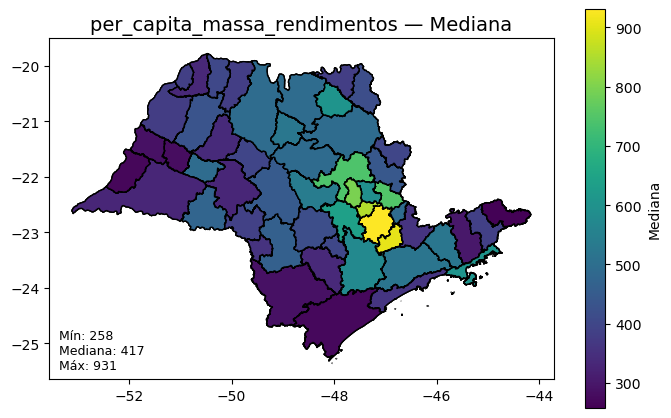

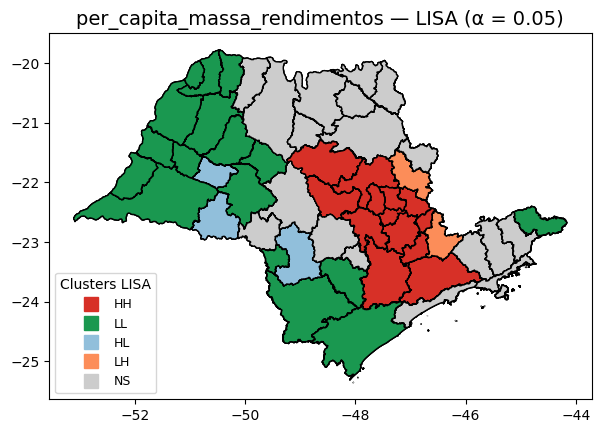

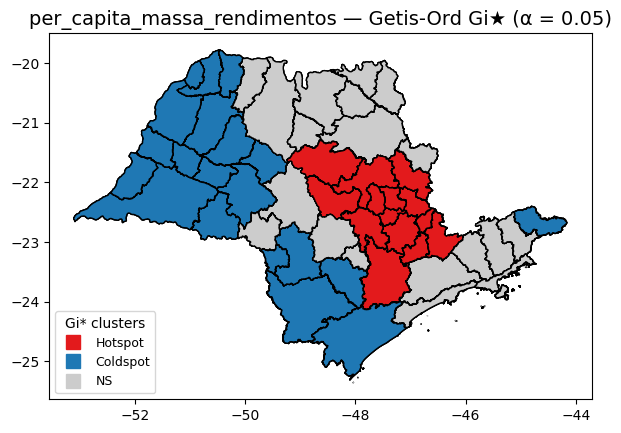

In [16]:
#  Plots completos para uma variável (mapas + Moran)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Escolha da variável
VAR_DESEJADA = "per_capita_massa_rendimentos"  # troque aqui se quiser
gdf_plot = gdfs_per_var[VAR_DESEJADA].copy()

# ----------------------------------------------------------------------
# Função para criar legenda interna (caixinha dentro do mapa)
# ----------------------------------------------------------------------
def legenda_interna(ax, titulo, mapping, loc="lower left"):
    """
    mapping = {"HH": "#d73027", ...}
    loc: 'upper right', 'upper left', 'lower left', 'lower right'
    """
    handles = [
        Line2D([0], [0], marker="s", linestyle="", markersize=10,
               color=cor, label=cat)
        for cat, cor in mapping.items()
    ]
    ax.legend(
        handles=handles,
        title=titulo,
        loc=loc,
        frameon=True,
        fontsize=9,
        title_fontsize=10
    )

# ----------------------------------------------------------------------
# 1) Mapa da mediana (com legenda de cores)
# ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

gdf_plot.plot(
    column="mediana_mean",
    cmap="viridis",
    edgecolor="black",
    legend=True,                     
    legend_kwds={
        "label": "Mediana",
        "shrink": 0.7
    },
    ax=ax
)

ax.set_title(f"{VAR_DESEJADA} — Mediana", fontsize=14)

val_min = gdf_plot["mediana_mean"].min()
val_med = gdf_plot["mediana_mean"].median()
val_max = gdf_plot["mediana_mean"].max()

texto_estat = (
    f"Mín: {val_min:,.0f}\n"
    f"Mediana: {val_med:,.0f}\n"
    f"Máx: {val_max:,.0f}"
)

ax.text(
    0.02, 0.02, texto_estat,
    transform=ax.transAxes,
    fontsize=9,
    va="bottom",
    ha="left",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)

plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------
# 2) LISA clusters
# ----------------------------------------------------------------------
palette_lisa = {
    "HH": "#d73027",
    "LL": "#1a9850",
    "HL": "#91bfdb",
    "LH": "#fc8d59",
    "NS": "#cccccc"
}

ax = gdf_plot.plot(
    color=gdf_plot["cluster_LISA"].map(palette_lisa),
    figsize=(7, 6),
    edgecolor="black"
)

ax.set_title(f"{VAR_DESEJADA} — LISA (α = 0.05)", fontsize=14)
legenda_interna(ax, "Clusters LISA", palette_lisa, loc="lower left")

plt.show()

# ----------------------------------------------------------------------
# 3) Hotspot / Coldspot (Gi*)
# ----------------------------------------------------------------------
palette_gi = {
    "Hotspot": "#e31a1c",
    "Coldspot": "#1f78b4",
    "NS": "#cccccc"
}

ax = gdf_plot.plot(
    color=gdf_plot["cluster_Gi"].map(palette_gi),
    figsize=(7, 6),
    edgecolor="black"
)

ax.set_title(f"{VAR_DESEJADA} — Getis-Ord Gi★ (α = 0.05)", fontsize=14)
legenda_interna(ax, "Gi* clusters", palette_gi, loc="lower left")

plt.show()




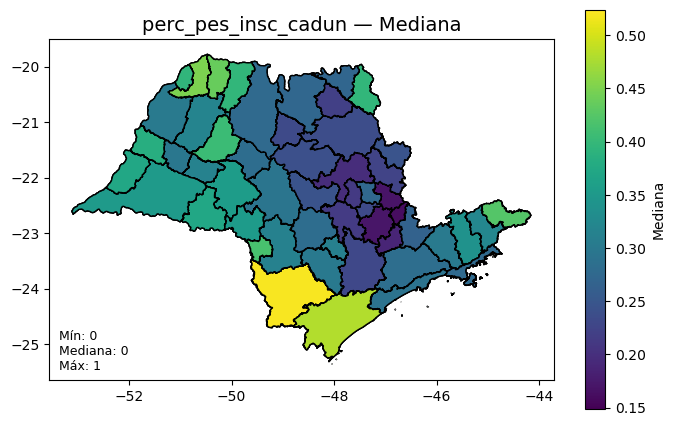

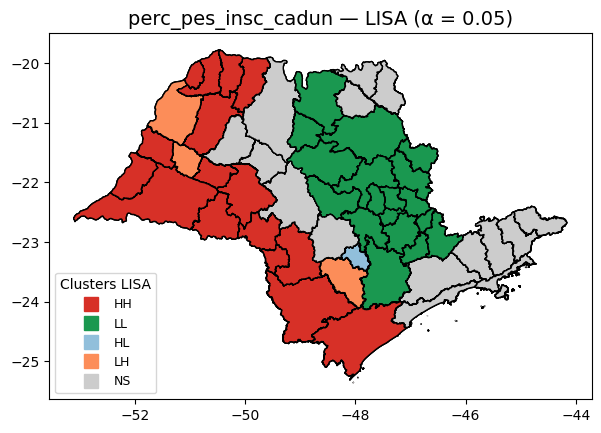

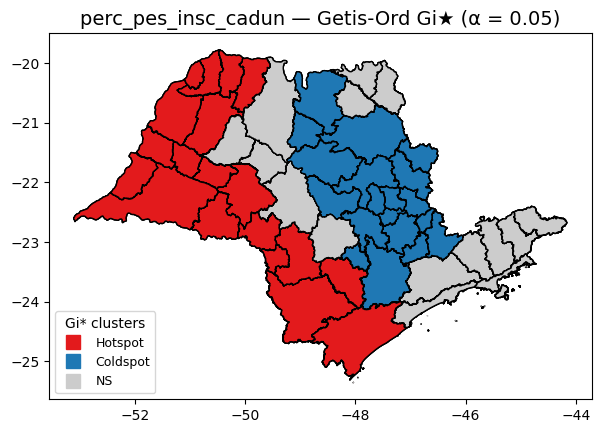

In [17]:
#  Plots completos para uma variável (mapas + Moran)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Escolha da variável
VAR_DESEJADA = "perc_pes_insc_cadun"  # troque aqui se quiser
gdf_plot = gdfs_per_var[VAR_DESEJADA].copy()

# ----------------------------------------------------------------------
# Função para criar legenda interna (caixinha dentro do mapa)
# ----------------------------------------------------------------------
def legenda_interna(ax, titulo, mapping, loc="lower left"):
    """
    mapping = {"HH": "#d73027", ...}
    loc: 'upper right', 'upper left', 'lower left', 'lower right'
    """
    handles = [
        Line2D([0], [0], marker="s", linestyle="", markersize=10,
               color=cor, label=cat)
        for cat, cor in mapping.items()
    ]
    ax.legend(
        handles=handles,
        title=titulo,
        loc=loc,
        frameon=True,
        fontsize=9,
        title_fontsize=10
    )

# ----------------------------------------------------------------------
# 1) Mapa da mediana (com legenda de cores)
# ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

gdf_plot.plot(
    column="mediana_mean",
    cmap="viridis",
    edgecolor="black",
    legend=True,                    # <<< ATIVE A LEGENDA
    legend_kwds={
        "label": "Mediana",
        "shrink": 0.7
    },
    ax=ax
)

ax.set_title(f"{VAR_DESEJADA} — Mediana", fontsize=14)

val_min = gdf_plot["mediana_mean"].min()
val_med = gdf_plot["mediana_mean"].median()
val_max = gdf_plot["mediana_mean"].max()

texto_estat = (
    f"Mín: {val_min:,.0f}\n"
    f"Mediana: {val_med:,.0f}\n"
    f"Máx: {val_max:,.0f}"
)

ax.text(
    0.02, 0.02, texto_estat,
    transform=ax.transAxes,
    fontsize=9,
    va="bottom",
    ha="left",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)

plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------
# 2) LISA clusters
# ----------------------------------------------------------------------
palette_lisa = {
    "HH": "#d73027",
    "LL": "#1a9850",
    "HL": "#91bfdb",
    "LH": "#fc8d59",
    "NS": "#cccccc"
}

ax = gdf_plot.plot(
    color=gdf_plot["cluster_LISA"].map(palette_lisa),
    figsize=(7, 6),
    edgecolor="black"
)

ax.set_title(f"{VAR_DESEJADA} — LISA (α = 0.05)", fontsize=14)
legenda_interna(ax, "Clusters LISA", palette_lisa, loc="lower left")

plt.show()

# ----------------------------------------------------------------------
# 3) Hotspot / Coldspot (Gi*)
# ----------------------------------------------------------------------
palette_gi = {
    "Hotspot": "#e31a1c",
    "Coldspot": "#1f78b4",
    "NS": "#cccccc"
}

ax = gdf_plot.plot(
    color=gdf_plot["cluster_Gi"].map(palette_gi),
    figsize=(7, 6),
    edgecolor="black"
)

ax.set_title(f"{VAR_DESEJADA} — Getis-Ord Gi★ (α = 0.05)", fontsize=14)
legenda_interna(ax, "Gi* clusters", palette_gi, loc="lower left")

plt.show()




In [71]:
pd.DataFrame(sorted(GDF["coluna"].dropna().unique()), columns=["coluna"])

,coluna
0,ipca_alimentos_bebidas
1,ipca_artigos_residencia
2,ipca_comunicacao
3,ipca_despesas_pessoais
4,ipca_educacao
5,ipca_geral
6,ipca_habitacao
7,ipca_saude_cuidados_pessoais
8,ipca_transportes
9,ipca_vestuario


### Moran bivariado local: onde renda alta convive com indicador ruim (ou vice-versa)

In [18]:
var1 = "per_capita_massa_rendimentos"
var2 = "taxa_qtd_formal_escolaridade_0"

gdf_v1 = GDF.loc[GDF["coluna"] == var1, ["cod_regiao", "geometry", "mediana_mean"]].copy()
gdf_v2 = GDF.loc[GDF["coluna"] == var2, ["cod_regiao", "mediana_mean"]].copy()

gdf_v1 = gdf_v1.rename(columns={"mediana_mean": f"med_{var1}"})
gdf_v2 = gdf_v2.rename(columns={"mediana_mean": f"med_{var2}"})

gdf_bv = gdf_v1.merge(gdf_v2, on="cod_regiao", how="inner")

gdf_bv = gpd.GeoDataFrame(gdf_bv, geometry="geometry", crs=GDF.crs)

print("N regiões bivariado:", len(gdf_bv))


N regiões bivariado: 477


In [19]:
from libpysal.weights import Queen

W_bv = Queen.from_dataframe(gdf_bv, use_index=True)
W_bv.transform = "R"

print("W_bv.n =", W_bv.n)


W_bv.n = 477


In [20]:
from esda.moran import Moran_BV, Moran_Local_BV
from libpysal.weights import lag_spatial
import numpy as np

y1 = gdf_bv[f"med_{var1}"].astype(float).values
y2 = gdf_bv[f"med_{var2}"].astype(float).values

mbv = Moran_BV(y1, y2, W_bv)          # global
mbv_loc = Moran_Local_BV(y1, y2, W_bv)  # local

print("Moran_BV I:", mbv.I)
print("p-valor (simulado):", mbv.p_sim)


Moran_BV I: 0.13332857250790797
p-valor (simulado): 0.001


In [21]:
gdf_bv["I_bv"]   = mbv_loc.Is
gdf_bv["p_bv"]   = mbv_loc.p_sim
gdf_bv["z_bv"]   = mbv_loc.z_sim

x_c = y1 - y1.mean()
wy2 = lag_spatial(W_bv, y2)
wy2_c = wy2 - wy2.mean()

def quad_bv(x, wy):
    return np.select(
        [(x>0)&(wy>0), (x<0)&(wy<0), (x>0)&(wy<0), (x<0)&(wy>0)],
        ["H-H", "L-L", "H-L", "L-H"], default="NS"
    )

gdf_bv["quad_bv_raw"] = quad_bv(x_c, wy2_c)
gdf_bv["quad_bv_sig"] = np.where(gdf_bv["p_bv"] <= 0.05, gdf_bv["quad_bv_raw"], "NS")


In [22]:
from libpysal.weights import W as WClass

def _build_W_sub(W_full, ids_subset_sorted):
    ids_set = set(ids_subset_sorted)
    neigh_sub = {}
    weights_sub = {}

    for i in ids_subset_sorted:
        neigh_i = W_full.neighbors.get(i, [])
        w_i     = W_full.weights.get(i, [])
        neigh_i2 = []
        w_i2     = []

        for j, wij in zip(neigh_i, w_i):
            if j in ids_set:
                neigh_i2.append(j)
                w_i2.append(wij)

        neigh_sub[i]   = neigh_i2
        weights_sub[i] = w_i2

    W_sub = WClass(neigh_sub, weights=weights_sub, id_order=ids_subset_sorted)
    W_sub.transform = "R"
    return W_sub


In [23]:
# 1) Estatísticas locais
gdf_bv["I_bv"] = mbv_loc.Is
gdf_bv["p_bv"] = mbv_loc.p_sim
gdf_bv["z_bv"] = mbv_loc.z_sim

print("\nResumo da estatística local (primeiras 5 linhas):")
print(gdf_bv[["I_bv", "p_bv", "z_bv"]].head())

# 2) Quadrantes
x_c   = y1 - y1.mean()
wy2   = lag_spatial(W_bv, y2)
wy2_c = wy2 - wy2.mean()

def quad_bv(x, wy):
    return np.select(
        [(x>0)&(wy>0),
         (x<0)&(wy<0),
         (x>0)&(wy<0),
         (x<0)&(wy>0)],
        ["H-H", "L-L", "H-L", "L-H"],
        default="NS"
    )

gdf_bv["quad_bv_raw"] = quad_bv(x_c, wy2_c)
gdf_bv["quad_bv_sig"] = np.where(gdf_bv["p_bv"] <= 0.05, gdf_bv["quad_bv_raw"], "NS")

# 3) Prints úteis
print("\nFrequência dos quadrantes brutos:")
print(gdf_bv["quad_bv_raw"].value_counts())

print("\nFrequência dos quadrantes (apenas significativos):")
print(gdf_bv["quad_bv_sig"].value_counts())

print("\nPrimeiras 5 linhas do resultado final:")
print(gdf_bv[["cod_regiao", f"med_{var1}", f"med_{var2}", "quad_bv_sig"]].head())



Resumo da estatística local (primeiras 5 linhas):
       I_bv   p_bv      z_bv
0  0.047616  0.117  1.245463
1  0.045488  0.127  1.195661
2  0.045810  0.126  1.202627
3  0.060411  0.115  1.243517
4  0.057713  0.124  1.195803

Frequência dos quadrantes brutos:
quad_bv_raw
L-L    153
L-H    138
H-H    132
H-L     54
Name: count, dtype: int64

Frequência dos quadrantes (apenas significativos):
quad_bv_sig
L-L    126
NS     117
H-H    105
L-H     93
H-L     36
Name: count, dtype: int64

Primeiras 5 linhas do resultado final:
   cod_regiao  med_per_capita_massa_rendimentos  \
0      350001                        514.183943   
1      350001                        514.183943   
2      350001                        514.183943   
3      350001                        528.373256   
4      350001                        528.373256   

   med_taxa_qtd_formal_escolaridade_0 quad_bv_sig  
0                            0.001570          NS  
1                            0.002125          NS  
2         

In [24]:
# Apenas casos significativos de "mismatch"
mask_mismatch = gdf_bv["quad_bv_sig"].isin(["L-H", "H-L"])
gdf_mismatch = gdf_bv[mask_mismatch].copy()

print("Total de L-H + H-L significativos:", len(gdf_mismatch))
print(gdf_mismatch["quad_bv_sig"].value_counts())


Total de L-H + H-L significativos: 129
quad_bv_sig
L-H    93
H-L    36
Name: count, dtype: int64


C:\Users\marcos\AppData\Local\Temp\ipykernel_9844\2676590645.py:14: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf_mismatch.plot(


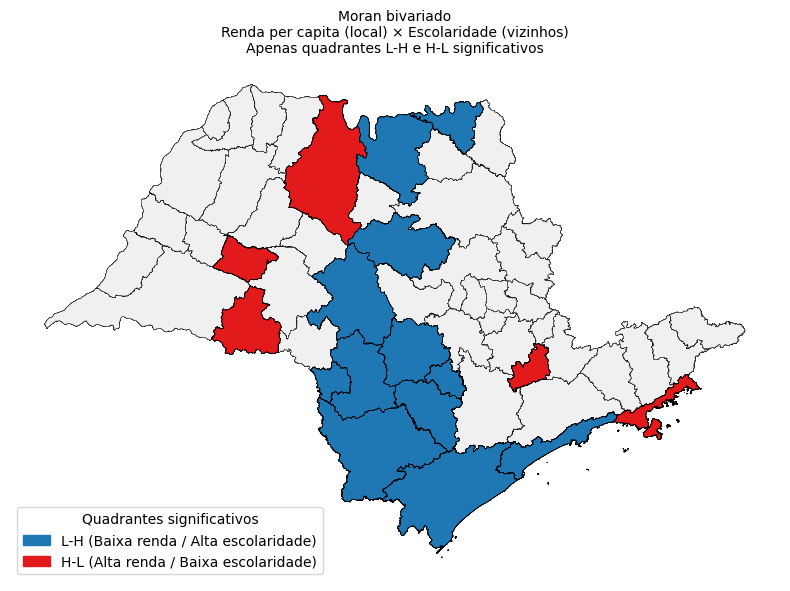

In [25]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 7))

# 1) Fundo: todas as regiões em cinza claro
gdf_bv.plot(ax=ax, color="#f0f0f0", edgecolor="black", linewidth=0.3)

# 2) Mismatches: L-H e H-L com cores diferentes
colors_mismatch = {
    "L-H": "#1f78b4",  # azul
    "H-L": "#e31a1c",  # vermelho
}

gdf_mismatch.plot(
    ax=ax,
    column="quad_bv_sig",
    categorical=True,
    legend=False,   # legenda será manual
    edgecolor="black",
    linewidth=0.5,
    color=gdf_mismatch["quad_bv_sig"].map(colors_mismatch),
)

# --- LEGENDA MANUAL ---
legend_patches = [
    mpatches.Patch(color=colors_mismatch["L-H"], label="L-H (Baixa renda / Alta escolaridade)"),
    mpatches.Patch(color=colors_mismatch["H-L"], label="H-L (Alta renda / Baixa escolaridade)")
]

ax.legend(handles=legend_patches, title="Quadrantes significativos", loc="lower left")

# Título
ax.set_title(
    "Moran bivariado\nRenda per capita (local) × Escolaridade (vizinhos)\nApenas quadrantes L-H e H-L significativos",
    fontsize=10,
)

ax.set_axis_off()
plt.tight_layout()
plt.show()


In [36]:
cols_show = [
    "cod_regiao",
    f"med_{var1}",
    f"med_{var2}",
    "quad_bv_sig",
]

gdf_mismatch[cols_show].sort_values("quad_bv_sig").head(20)


,cod_regiao,med_per_capita_massa_rendimentos,med_taxa_qtd_formal_escolaridade_0,quad_bv_sig
122,350014,472.958327,0.001523,H-L
222,350025,494.131313,0.002100,H-L
221,350025,476.433937,0.002034,H-L
220,350025,476.433937,0.002250,H-L
219,350025,476.433937,0.002100,H-L
143,350016,493.902361,0.002187,H-L
142,350016,493.902361,0.002415,H-L
223,350025,494.131313,0.002250,H-L
141,350016,493.902361,0.002469,H-L
139,350016,497.512046,0.002415,H-L


In [26]:
print("Média renda (y1.mean()):", y1.mean())
print("Mínimo / máximo renda:", y1.min(), y1.max())

# Veja alguns casos H-L e compare com a média:
print(gdf_mismatch[gdf_mismatch["quad_bv_sig"]=="H-L"][
      ["med_per_capita_massa_rendimentos", "med_taxa_qtd_formal_escolaridade_0"]
].head(10))


Média renda (y1.mean()): 461.3828605523668
Mínimo / máximo renda: 257.7753718366899 931.0285438358349
     med_per_capita_massa_rendimentos  med_taxa_qtd_formal_escolaridade_0
120                        472.958327                            0.001827
121                        472.958327                            0.001614
122                        472.958327                            0.001523
123                        475.989788                            0.001827
124                        475.989788                            0.001614
125                        475.989788                            0.001523
138                        497.512046                            0.002469
139                        497.512046                            0.002415
140                        497.512046                            0.002187
141                        493.902361                            0.002469


In [27]:
# Prova de que H é só "acima da média":
gdf_bv["x_c"] = y1 - y1.mean()
print(gdf_bv[["med_per_capita_massa_rendimentos", "x_c", "quad_bv_sig"]].head(15))


    med_per_capita_massa_rendimentos         x_c quad_bv_sig
0                         514.183943   52.801083          NS
1                         514.183943   52.801083          NS
2                         514.183943   52.801083          NS
3                         528.373256   66.990396          NS
4                         528.373256   66.990396          NS
5                         528.373256   66.990396          NS
6                         518.554355   57.171495          NS
7                         518.554355   57.171495          NS
8                         518.554355   57.171495          NS
9                         350.191985 -111.190876         L-H
10                        350.191985 -111.190876         L-H
11                        350.191985 -111.190876         L-H
12                        369.896898  -91.485963         L-H
13                        369.896898  -91.485963         L-H
14                        369.896898  -91.485963         L-H


No Moran bivariado, classificamos as regiões como ‘altas’ ou ‘baixas’ em renda per capita em relação à média do conjunto de regiões analisadas. Assim, ‘H’ indica renda acima da média amostral, ainda que em termos absolutos os valores permaneçam baixos.

Clusterização de pesfis espaciais

In [28]:
# escolha as variáveis (exemplo – ajuste à sua conveniência)
vars_cluster = [
    "per_capita_massa_rendimentos",
    "per_capita_pib_industria" 
]


In [32]:
# Filtra apenas as variáveis selecionadas
df_sel = GDF.loc[GDF["coluna"].isin(vars_cluster),
                 ["cod_regiao", "coluna", "mediana_mean", "geometry"]].copy()

# Tira duplicações de geometry por região (pega a primeira)
geom_por_regiao = (
    df_sel[["cod_regiao", "geometry"]]
    .drop_duplicates(subset="cod_regiao")
    .set_index("cod_regiao")
)

# Pivot: 1 linha por região, 1 coluna por variável
df_wide = (
    df_sel
    .pivot_table(index="cod_regiao",
                 columns="coluna",
                 values="mediana_mean")
)

# Mantém apenas regiões com TODAS as variáveis presentes
df_wide = df_wide.dropna()

print("Formato wide:", df_wide.shape)
df_wide.head()


Formato wide: (53, 2)


coluna,per_capita_massa_rendimentos,per_capita_pib_industria
cod_regiao,,
350001,520.370518,6965.862865
350002,360.709625,2455.156344
350003,563.236347,10634.717553
350004,292.100696,1871.220364
350005,281.942942,2066.834293


In [33]:
import geopandas as gpd

# Junta geometria na tabela wide
gdf_cluster = df_wide.join(geom_por_regiao, how="inner")
gdf_cluster = gpd.GeoDataFrame(gdf_cluster,
                               geometry="geometry",
                               crs=GDF.crs)

print("N regiões com todas as variáveis:", len(gdf_cluster))


N regiões com todas as variáveis: 53


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

X = gdf_cluster[vars_cluster].values

# Padroniza (média 0, desvio 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define número de clusters (ajuste conforme quiser)
K = 3  # por exemplo, tipos A, B, C, D

kmeans = KMeans(n_clusters=K, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_scaled)

gdf_cluster["cluster"] = labels  # 0..K-1

print("Contagem por cluster:")
print(gdf_cluster["cluster"].value_counts().sort_index())


Contagem por cluster:
cluster
0    35
1     5
2    13
Name: count, dtype: int64


c:\Users\marcos\anaconda3\envs\geo\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [35]:
cluster_profiles = (
    gdf_cluster
    .groupby("cluster")[vars_cluster]
    .mean()
    .round(2)
)

print("Perfis médios por cluster:")
display(cluster_profiles)


Perfis médios por cluster:


,per_capita_massa_rendimentos,per_capita_pib_industria
cluster,,
0,374.38,2807.75
1,796.82,26467.46
2,566.61,7614.91


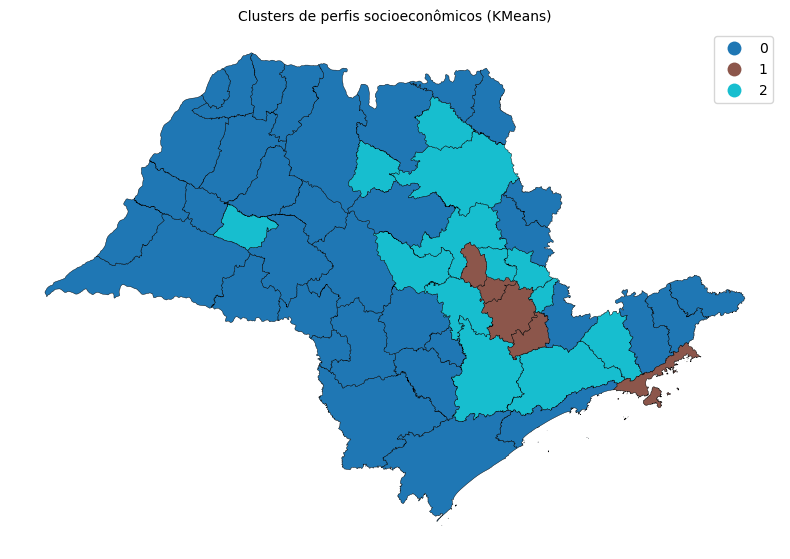

In [105]:
fig, ax = plt.subplots(figsize=(8, 7))

gdf_cluster.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    legend=True,
    edgecolor="black",
    linewidth=0.3
)

ax.set_title("Clusters de perfis socioeconômicos (KMeans)", fontsize=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()


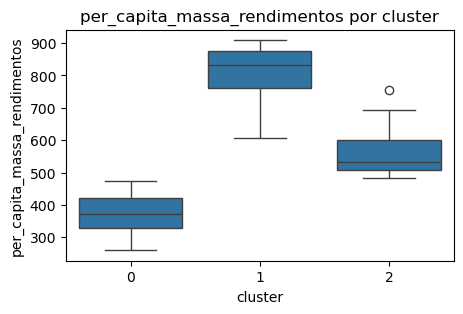

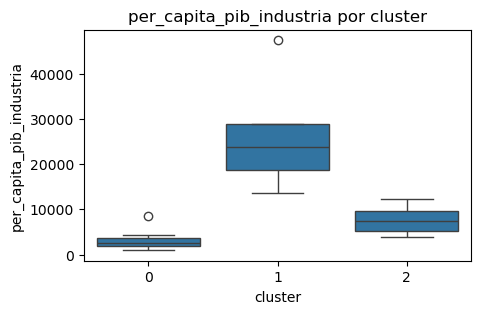

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

for var in vars_cluster:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=gdf_cluster["cluster"], y=gdf_cluster[var])
    plt.title(f"{var} por cluster")
    plt.show()


#### Análise de resíduos do modelo

In [111]:
# === 0. Configuração ===
ano_modelo = 2018  # ajuste se quiser outro ano

# vou assumir que GDF tem pelo menos:
# cod_regiao, nome_regiao, coluna, ano, mediana_mean, geometry

cols_base = ["cod_regiao", "nome_regiao", "coluna", "ano", "mediana_mean", "geometry"]
df_base = GDF[cols_base].copy()

# === 1. Filtra o ano desejado ===
df_ano = df_base[df_base["ano"] == ano_modelo].copy()
print("N linhas no ano", ano_modelo, ":", len(df_ano))

# === 2. Geometria por região (uma só) ===
geom_por_regiao = (
    df_ano[["cod_regiao", "nome_regiao", "geometry"]]
    .drop_duplicates(subset="cod_regiao")
    .set_index("cod_regiao")
)

# === 3. Pivot: 1 linha por região, 1 coluna por variável ===
df_wide_allvars = (
    df_ano
    .pivot_table(
        index="cod_regiao",     # cada região vira uma linha
        columns="coluna",       # cada variável (ipca_*, per_capita_*, etc.)
        values="mediana_mean"   # valor que você quer usar na análise
    )
)

print("Formato antes do dropna:", df_wide_allvars.shape)

# Remove regiões com NA em muitas variáveis (ajuste se quiser outra regra)
df_wide_allvars = df_wide_allvars.dropna(axis=0)

print("Formato depois do dropna:", df_wide_allvars.shape)
df_wide_allvars.head()



N linhas no ano 2018 : 2279
Formato antes do dropna: (53, 43)
Formato depois do dropna: (53, 43)


coluna,ipca_alimentos_bebidas,ipca_artigos_residencia,ipca_comunicacao,ipca_despesas_pessoais,ipca_educacao,ipca_geral,ipca_habitacao,ipca_saude_cuidados_pessoais,ipca_transportes,ipca_vestuario,per_capita_massa_rendimentos,per_capita_pib,per_capita_pib_agropecuaria,per_capita_pib_impostos_liq_sub,per_capita_pib_industria,per_capita_pib_servicos,per_capita_pib_servicos_adm_publica,per_capita_pib_valor_add,perc_65_menos_Idoso_BPC,perc_Ido_BPC,perc_PCD_BPC,perc_Pes_PBF,perc_Pop_65_mais,perc_cadunicoF_CAD_EP,perc_cadunicoFam_PBF,perc_n_fam_rua,perc_pes_insc_cadun,perc_pes_rf_ate_meio_sm,taxa_qtd_formal_Administração_Pública,taxa_qtd_formal_Agropecuária,taxa_qtd_formal_Alojamento_e_Alimentação,taxa_qtd_formal_Atividades_Profissionais_e_Técnicas,taxa_qtd_formal_Comércio,taxa_qtd_formal_Indústria_de_Transformação,taxa_qtd_formal_Organismos_Internacionais,taxa_qtd_formal_Outros_Serviços,taxa_qtd_formal_Serviços_Financeiros,taxa_qtd_formal_Transporte_e_Correios,taxa_qtd_formal_escolaridade_0,taxa_qtd_formal_escolaridade_1,taxa_qtd_formal_escolaridade_2,taxa_qtd_formal_escolaridade_3,taxa_qtd_formal_escolaridade_4
cod_regiao,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
350001,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,514.183943,33940.400103,14.334417,5090.996250,6394.851347,15372.585506,3739.280672,27792.852949,0.069968,0.008875,0.006743,0.133151,0.079689,0.135914,0.161400,0.000431,0.261274,0.216668,0.121276,0.001463,0.032450,0.013577,0.222693,0.223274,0.0,0.017746,0.009693,0.055418,0.001570,0.072790,0.131490,0.604712,0.175838
350002,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,350.191985,21828.049205,135.407067,1298.828259,2384.764712,12891.476389,4614.984194,20363.010067,0.092272,0.012376,0.010416,0.156331,0.107086,0.158614,0.176449,0.000994,0.279851,0.245700,0.208477,0.002776,0.059282,0.013093,0.279394,0.022491,0.0,0.036728,0.010634,0.055120,0.001825,0.082087,0.169295,0.569438,0.174658
350003,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,556.243002,35178.589799,719.956400,4547.379014,9878.742848,14733.293859,4086.384379,30538.860299,0.091301,0.006922,0.006592,0.104507,0.098423,0.105050,0.134758,0.000384,0.229746,0.190186,0.131888,0.049062,0.032049,0.010075,0.175852,0.296642,0.0,0.016723,0.007626,0.032449,0.002238,0.092379,0.168145,0.584070,0.149383
350004,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,289.870225,17917.197768,3658.132398,941.575396,1759.980288,6208.158568,4220.601239,17083.503647,0.094800,0.007584,0.011711,0.293912,0.103926,0.149582,0.173545,0.000127,0.524040,0.448587,0.292310,0.229673,0.010057,0.004130,0.160755,0.085758,0.0,0.009315,0.003424,0.029454,0.002381,0.128276,0.208259,0.489172,0.129398
350005,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,281.704270,26425.870974,3244.724922,1066.917271,2118.648041,10995.094988,4197.434406,25031.664712,0.091995,0.018797,0.018520,0.243879,0.110803,0.103399,0.141045,0.000307,0.490732,0.416129,0.312119,0.147735,0.050786,0.011807,0.172765,0.046800,0.0,0.009370,0.008098,0.023843,0.005418,0.133665,0.179838,0.522712,0.154975


In [112]:
# junta as colunas numéricas com a geometria
gdf_wide = df_wide_allvars.join(geom_por_regiao, how="inner")

gdf_wide = gpd.GeoDataFrame(
    gdf_wide,
    geometry="geometry",
    crs=GDF.crs
)

print("N regiões em gdf_wide:", len(gdf_wide))
gdf_wide.head()


N regiões em gdf_wide: 53


,ipca_alimentos_bebidas,ipca_artigos_residencia,ipca_comunicacao,ipca_despesas_pessoais,ipca_educacao,ipca_geral,ipca_habitacao,ipca_saude_cuidados_pessoais,ipca_transportes,ipca_vestuario,per_capita_massa_rendimentos,per_capita_pib,per_capita_pib_agropecuaria,per_capita_pib_impostos_liq_sub,per_capita_pib_industria,per_capita_pib_servicos,per_capita_pib_servicos_adm_publica,per_capita_pib_valor_add,perc_65_menos_Idoso_BPC,perc_Ido_BPC,perc_PCD_BPC,perc_Pes_PBF,perc_Pop_65_mais,perc_cadunicoF_CAD_EP,perc_cadunicoFam_PBF,perc_n_fam_rua,perc_pes_insc_cadun,perc_pes_rf_ate_meio_sm,taxa_qtd_formal_Administração_Pública,taxa_qtd_formal_Agropecuária,taxa_qtd_formal_Alojamento_e_Alimentação,taxa_qtd_formal_Atividades_Profissionais_e_Técnicas,taxa_qtd_formal_Comércio,taxa_qtd_formal_Indústria_de_Transformação,taxa_qtd_formal_Organismos_Internacionais,taxa_qtd_formal_Outros_Serviços,taxa_qtd_formal_Serviços_Financeiros,taxa_qtd_formal_Transporte_e_Correios,taxa_qtd_formal_escolaridade_0,taxa_qtd_formal_escolaridade_1,taxa_qtd_formal_escolaridade_2,taxa_qtd_formal_escolaridade_3,taxa_qtd_formal_escolaridade_4,nome_regiao,geometry
cod_regiao,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
350001,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,514.183943,33940.400103,14.334417,5090.996250,6394.851347,15372.585506,3739.280672,27792.852949,0.069968,0.008875,0.006743,0.133151,0.079689,0.135914,0.161400,0.000431,0.261274,0.216668,0.121276,0.001463,0.032450,0.013577,0.222693,0.223274,0.0,0.017746,0.009693,0.055418,0.001570,0.072790,0.131490,0.604712,0.175838,São Paulo,"POLYGON ((-47.00221 -24.05627, -47.00285 -24.0..."
350002,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,350.191985,21828.049205,135.407067,1298.828259,2384.764712,12891.476389,4614.984194,20363.010067,0.092272,0.012376,0.010416,0.156331,0.107086,0.158614,0.176449,0.000994,0.279851,0.245700,0.208477,0.002776,0.059282,0.013093,0.279394,0.022491,0.0,0.036728,0.010634,0.055120,0.001825,0.082087,0.169295,0.569438,0.174658,Santos,"MULTIPOLYGON (((-47.0313 -24.42844, -47.03124 ..."
350003,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,556.243002,35178.589799,719.956400,4547.379014,9878.742848,14733.293859,4086.384379,30538.860299,0.091301,0.006922,0.006592,0.104507,0.098423,0.105050,0.134758,0.000384,0.229746,0.190186,0.131888,0.049062,0.032049,0.010075,0.175852,0.296642,0.0,0.016723,0.007626,0.032449,0.002238,0.092379,0.168145,0.584070,0.149383,Sorocaba,"POLYGON ((-47.35592 -24.02212, -47.35629 -24.0..."
350004,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,289.870225,17917.197768,3658.132398,941.575396,1759.980288,6208.158568,4220.601239,17083.503647,0.094800,0.007584,0.011711,0.293912,0.103926,0.149582,0.173545,0.000127,0.524040,0.448587,0.292310,0.229673,0.010057,0.004130,0.160755,0.085758,0.0,0.009315,0.003424,0.029454,0.002381,0.128276,0.208259,0.489172,0.129398,Itapeva,"POLYGON ((-48.91204 -24.6743, -48.91121 -24.67..."
350005,4.030782,3.759616,-0.080826,2.989517,5.31092,3.745482,4.724189,3.951694,4.202469,0.602078,281.704270,26425.870974,3244.724922,1066.917271,2118.648041,10995.094988,4197.434406,25031.664712,0.091995,0.018797,0.018520,0.243879,0.110803,0.103399,0.141045,0.000307,0.490732,0.416129,0.312119,0.147735,0.050786,0.011807,0.172765,0.046800,0.0,0.009370,0.008098,0.023843,0.005418,0.133665,0.179838,0.522712,0.154975,Registro,"MULTIPOLYGON (((-48.03811 -25.35732, -48.03819..."


In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# separa só as colunas numéricas (todas as variáveis do dataset)
vars_all = df_wide_allvars.columns.tolist()

X = df_wide_allvars[vars_all].values

# padroniza (média 0, desvio 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA com, por exemplo, 5 componentes
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

print("Proporção de variância explicada por componente:")
print(pca.explained_variance_ratio_)


Proporção de variância explicada por componente:
[0.3673589  0.14312587 0.12436008 0.07779663 0.06166164]


In [124]:


# loadings = matriz (n_variaveis × n_componentes)
loadings = pca.components_.T   # agora cada coluna é um PC e cada linha é uma variável

# DataFrame organizado
df_loadings = pd.DataFrame(
    loadings,
    index=vars_exp,
    columns=[f"PC{i+1}" for i in range(n_components)]
)

# Mostra as 10 variáveis mais importantes EM VALOR ABSOLUTO para cada componente
top_n = 10  # ajuste se quiser mais/menos

for pc in df_loadings.columns:
    print(f"\n===== {pc} — variáveis que mais explicam esse componente =====")
    display(
        df_loadings[pc]
        .abs()                 # importância = valor absoluto do loading
        .sort_values(ascending=False)
        .head(top_n)
        .to_frame("loading_abs")
    )



===== PC1 — variáveis que mais explicam esse componente =====


,loading_abs
per_capita_pib_servicos,0.242697
taxa_qtd_formal_Administração_Pública,0.239102
perc_pes_insc_cadun,0.228180
perc_Pop_65_mais,0.227608
perc_65_menos_Idoso_BPC,0.225672
taxa_qtd_formal_Transporte_e_Correios,0.224233
per_capita_pib_impostos_liq_sub,0.215224
per_capita_pib,0.214199
per_capita_pib_industria,0.213214
per_capita_pib_agropecuaria,0.212297



===== PC2 — variáveis que mais explicam esse componente =====


,loading_abs
perc_Pes_PBF,0.359136
perc_cadunicoFam_PBF,0.309767
perc_pes_rf_ate_meio_sm,0.292371
perc_Ido_BPC,0.290092
taxa_qtd_formal_Indústria_de_Transformação,0.274772
perc_cadunicoF_CAD_EP,0.237130
taxa_qtd_formal_Comércio,0.212408
taxa_qtd_formal_Outros_Serviços,0.207721
per_capita_pib_impostos_liq_sub,0.206347
perc_pes_insc_cadun,0.188158



===== PC3 — variáveis que mais explicam esse componente =====


,loading_abs
per_capita_pib_servicos_adm_publica,0.372321
taxa_qtd_formal_escolaridade_4,0.347375
taxa_qtd_formal_escolaridade_2,0.296434
taxa_qtd_formal_escolaridade_0,0.250135
taxa_qtd_formal_Administração_Pública,0.237830
per_capita_pib_valor_add,0.212845
taxa_qtd_formal_Agropecuária,0.207823
per_capita_pib_industria,0.199190
per_capita_pib,0.197391
taxa_qtd_formal_escolaridade_1,0.186072



===== PC4 — variáveis que mais explicam esse componente =====


,loading_abs
taxa_qtd_formal_escolaridade_0,0.371741
per_capita_pib_industria,0.285333
per_capita_pib_valor_add,0.272479
taxa_qtd_formal_Agropecuária,0.265695
taxa_qtd_formal_escolaridade_4,0.265134
per_capita_pib,0.244519
taxa_qtd_formal_escolaridade_1,0.228407
taxa_qtd_formal_Serviços_Financeiros,0.217119
perc_65_menos_Idoso_BPC,0.211728
perc_Pop_65_mais,0.207184



===== PC5 — variáveis que mais explicam esse componente =====


,loading_abs
taxa_qtd_formal_Alojamento_e_Alimentação,0.338937
perc_cadunicoF_CAD_EP,0.337865
taxa_qtd_formal_Outros_Serviços,0.288051
per_capita_pib_impostos_liq_sub,0.280227
perc_Pes_PBF,0.263833
taxa_qtd_formal_escolaridade_0,0.255020
perc_cadunicoFam_PBF,0.244681
perc_n_fam_rua,0.242730
taxa_qtd_formal_Atividades_Profissionais_e_Técnicas,0.225048
perc_pes_rf_ate_meio_sm,0.204404


PCA1: Eixo de desenvolvimento estrutural geral — estrutura produtiva, setor público forte, envelhecimento populacional e PIB amplo.

PCA2: Componente captura pobreza, dependência assistencial e baixa qualificação.

PCA3: Representa um eixo “capital humano + estrutura institucional”.

In [115]:
# %% [1] Dependente, seleção de variáveis e preparação do PCA

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Define variável dependente (y)
dep_var = "per_capita_massa_rendimentos"

if dep_var not in df_wide_allvars.columns:
    raise ValueError(f"{dep_var} não está em df_wide_allvars.columns")

# 2) Define quais variáveis vão entrar no PCA
#    Aqui usei "todas as colunas numéricas", exceto a própria dependente
vars_all = df_wide_allvars.columns.tolist()
vars_exp = [v for v in vars_all if v != dep_var]

print("N variáveis explicativas no PCA:", len(vars_exp))

# 3) Monta X (todas as variáveis explicativas) e y (dependente)
X = df_wide_allvars[vars_exp].values
y = df_wide_allvars[dep_var].values.reshape(-1, 1)  # (n, 1)

print("Formato X:", X.shape, "| Formato y:", y.shape)

# 4) Padroniza X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5) PCA – escolha número de componentes (ajuste se quiser)
n_components = 5   # por exemplo: 3 a 6 componentes
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print("Variância explicada por componente:")
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var_ratio:.3f}")

# 6) Vamos usar, por exemplo, os 3 primeiros componentes no modelo
X_exp = X_pca[:, :3]   # (n, 3)
print("Formato X_exp (para OLS):", X_exp.shape)


N variáveis explicativas no PCA: 42
Formato X: (53, 42) | Formato y: (53, 1)
Variância explicada por componente:
PC1: 0.359
PC2: 0.140
PC3: 0.128
PC4: 0.080
PC5: 0.063
Formato X_exp (para OLS): (53, 3)


In [116]:
# %% [2] Construção da matriz de pesos W para gdf_wide

from libpysal.weights import Queen

# Garante que gdf_wide está alinhado ao df_wide_allvars (mesmo índice)
# (Se você já garantiu isso, pode ignorar este reindex)
gdf_wide = gdf_wide.loc[df_wide_allvars.index]

# Matriz de pesos Queen para essas regiões
W_pca = Queen.from_dataframe(gdf_wide, use_index=True)
W_pca.transform = "R"

print("W_pca.n =", W_pca.n)


W_pca.n = 53


In [117]:
# %% [3] OLS com os componentes principais (spreg)

from spreg import OLS

# Nomes simbólicos para os PCs (apenas para aparecer no summary)
names_pc = [f"PC{i+1}" for i in range(X_exp.shape[1])]

model_ols_pca = OLS(
    y, X_exp,
    name_y=dep_var,
    name_x=names_pc,
    w=W_pca,
    spat_diag=True,   # inclui diagnósticos espaciais
    moran=True        # calcula Moran dos resíduos automaticamente
)

print(model_ols_pca.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :per_capita_massa_rendimentos                Number of Observations:          53
Mean dependent var  :    455.0420                Number of Variables   :           4
S.D. dependent var  :    149.3171                Degrees of Freedom    :          49
R-squared           :      0.8428
Adjusted R-squared  :      0.8331
Sum squared residual:      182300                F-statistic           :     87.5417
Sigma-square        :    3720.402                Prob(F-statistic)     :   1.081e-19
S.E. of regression  :      60.995                Log likelihood        :    -290.996
Sigma-square ML     :    3439.617                Akaike info criterion :     589.993
S.E of regression ML:     58.6482                Schwarz criterion     :     597.874

--------------------------------------------

In [118]:
# %% [4] Resíduos do modelo + Moran global dos resíduos

from esda import Moran

# Resíduos (u) no spreg já vêm como vetor (n, 1)
resid = np.array(model_ols_pca.u).flatten()
gdf_wide["resid_ols_pca"] = resid

print("Resumo dos resíduos:")
print(pd.Series(resid).describe())

# Moran global dos resíduos
m_res = Moran(resid, W_pca)

print("\nMoran I (resíduos OLS-PCA):", m_res.I)
print("p_norm:", m_res.p_norm)
print("p_sim :", m_res.p_sim)


Resumo dos resíduos:
count    5.300000e+01
mean     4.182818e-14
std      5.920949e+01
min     -9.756986e+01
25%     -4.461767e+01
50%     -1.461341e+01
75%      4.917497e+01
max      1.802367e+02
dtype: float64

Moran I (resíduos OLS-PCA): -0.11679560760795872
p_norm: 0.27403101350082915
p_sim : 0.133


In [119]:
# %% [5] Moran Local (LISA) nos resíduos + quadrantes

from esda import Moran_Local
from libpysal.weights import lag_spatial

m_loc_res = Moran_Local(resid, W_pca)

gdf_wide["I_resid"] = m_loc_res.Is
gdf_wide["p_resid"] = m_loc_res.p_sim
gdf_wide["z_resid"] = m_loc_res.z_sim

# Centro dos resíduos e do lag dos resíduos
resid_c = resid - resid.mean()
w_resid = lag_spatial(W_pca, resid)
w_resid_c = w_resid - w_resid.mean()

def quad_res(x, wx):
    """
    Quadrantes dos resíduos:
    H-H: resíduo alto cercado de alto
    L-L: resíduo baixo cercado de baixo
    H-L: resíduo alto cercado de baixo
    L-H: resíduo baixo cercado de alto
    """
    return np.select(
        [(x > 0) & (wx > 0),
         (x < 0) & (wx < 0),
         (x > 0) & (wx < 0),
         (x < 0) & (wx > 0)],
        ["H-H", "L-L", "H-L", "L-H"],
        default="NS"
    )

gdf_wide["quad_res_raw"] = quad_res(resid_c, w_resid_c)
gdf_wide["quad_res_sig"] = np.where(
    gdf_wide["p_resid"] <= 0.05,
    gdf_wide["quad_res_raw"],
    "NS"
)

print("Frequência dos quadrantes de resíduos (apenas significativos):")
print(gdf_wide["quad_res_sig"].value_counts())


Frequência dos quadrantes de resíduos (apenas significativos):
quad_res_sig
NS     49
L-H     3
L-L     1
Name: count, dtype: int64


In [120]:
# %% [6] Getis-Ord Gi* nos resíduos (hotspots e coldspots de erro)

from esda.getisord import G_Local

g_local_res = G_Local(resid, W_pca)

gdf_wide["Gi_resid"]   = g_local_res.Gs
gdf_wide["p_Gi_resid"] = g_local_res.p_sim

gdf_wide["Gi_cat_resid"] = np.where(
    gdf_wide["p_Gi_resid"] <= 0.05,
    np.where(gdf_wide["Gi_resid"] > 0, "Hotspot_resid", "Coldspot_resid"),
    "NS"
)

print("Hotspots/Coldspots dos resíduos:")
print(gdf_wide["Gi_cat_resid"].value_counts())


Hotspots/Coldspots dos resíduos:
Gi_cat_resid
NS                49
Hotspot_resid      3
Coldspot_resid     1
Name: count, dtype: int64


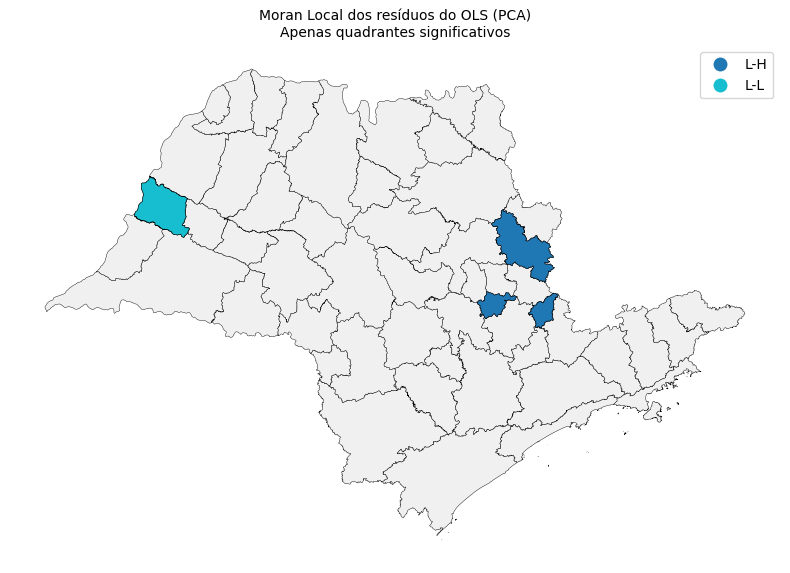

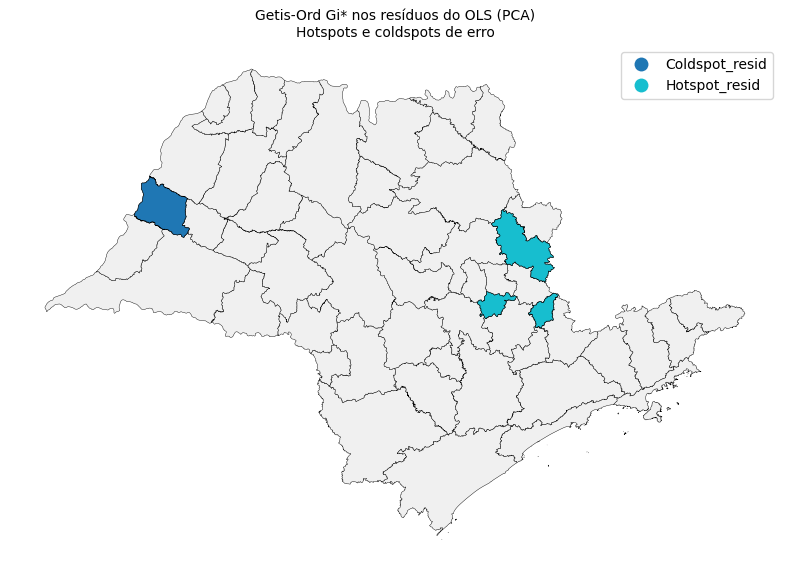

In [ ]:
# %% [7] Mapas 
import matplotlib.pyplot as plt

# 1) Quadrantes significativos dos resíduos (LISA)
fig, ax = plt.subplots(figsize=(8, 7))

gdf_wide.plot(ax=ax, color="#f0f0f0", edgecolor="black", linewidth=0.3)

gdf_wide[gdf_wide["quad_res_sig"] != "NS"].plot(
    ax=ax,
    column="quad_res_sig",
    categorical=True,
    legend=True,
    edgecolor="black",
    linewidth=0.4
)

ax.set_title("Moran Local dos resíduos do OLS (PCA)\nApenas quadrantes significativos", fontsize=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# 2) Hotspots/Coldspots dos resíduos (Gi*)
fig, ax = plt.subplots(figsize=(8, 7))

gdf_wide.plot(ax=ax, color="#f0f0f0", edgecolor="black", linewidth=0.3)

gdf_wide[gdf_wide["Gi_cat_resid"] != "NS"].plot(
    ax=ax,
    column="Gi_cat_resid",
    categorical=True,
    legend=True,
    edgecolor="black",
    linewidth=0.4
)

ax.set_title("Getis-Ord Gi* nos resíduos do OLS (PCA)\nHotspots e coldspots de erro", fontsize=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [126]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import r2_score
import numpy as np

dep_var = "per_capita_massa_rendimentos"
X = df_wide_allvars.drop(columns=[dep_var]).values
y = df_wide_allvars[dep_var].values

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3)),
    ("reg", LinearRegression())
])

cv = LeaveOneOut()

# 1) previsões LOO para TODAS as observações
y_pred = cross_val_predict(pipe, X, y, cv=cv)

# 2) R² global entre observado e predito
r2_loo = r2_score(y, y_pred)

# 3) RMSE global (mesmo espírito do que vc já fez)
rmse_loo = np.sqrt(np.mean((y - y_pred)**2))

print(f"R² (LOO, global): {r2_loo:.3f}")
print(f"RMSE (LOO, global): {rmse_loo:.2f}")


R² (LOO, global): 0.800
RMSE (LOO, global): 66.07
